<a href="https://colab.research.google.com/github/ShenghanZhang/Blog-Back-Up/blob/master/two_sigma_rental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/sigma two rental')

In [7]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.tag import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict,Counter
from tqdm import  tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import xgboost as xgb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
color = sns.color_palette()

%matplotlib inline

In [37]:
# import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [55]:
PATH = '/content/drive/My Drive/Colab Notebooks/sigma two rental/'

In [41]:
df_train = pd.read_json('/content/drive/My Drive/Colab Notebooks/sigma two rental/input/train.json.zip',compression='zip')
df_test = pd.read_json('/content/drive/My Drive/Colab Notebooks/sigma two rental/input/test.json.zip',compression='zip')

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (49352, 15)
Training Set Memory Usage = 6.02 MB
Test Set Shape = (74659, 14)
Test Set Memory Usage = 8.54 MB


### Naive features

In [12]:
features_to_use = ['bathrooms', 'bedrooms', 'price','listing_id']

In [42]:
df_train['room_diff'] = df_train['bedrooms'] - df_train['bathrooms']
df_train['room_sum'] = df_train['bedrooms'] - df_train['bathrooms']
df_train['price_t'] = df_train['price'] /(df_train['bedrooms'] + df_train['bathrooms'] + 1)
df_train['price_t1'] = df_train['price'] /(df_train['bedrooms'] +  1)


df_train["created"] = pd.to_datetime(df_train["created"])
df_train["created_year"] = df_train["created"].dt.year
df_train["created_month"] = df_train["created"].dt.month
df_train["created_day"] = df_train["created"].dt.day
df_train["created_hour"] = df_train["created"].dt.hour
df_train["created_dayofweek"] = df_train["created"].dt.dayofweek
df_train['total_days'] = (df_train["created"] - pd.Timestamp('2016-04-02 23:59:59')).astype('timedelta64[h]') /24

df_train['n_photos'] = df_train.photos.apply(len)

In [14]:
features_to_add = ['total_days','price_t','price_t1','room_diff','room_sum','n_photos']
features_to_use.extend(features_to_add)

### longitude and latitude
1. clusters

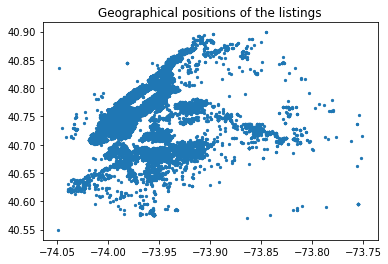

In [15]:
plt.scatter(df_train.loc[(df_train["longitude"]<-73.75)&(df_train["longitude"]>-74.05)&(df_train["latitude"]>40.4)&(df_train["latitude"]<40.9),"longitude"],
                      df_train.loc[(df_train["latitude"]>40.4)&(df_train["latitude"]<40.9)&(df_train["longitude"]<-73.75)&(df_train["longitude"]>-74.05),"latitude"], s=5)
plt.title("Geographical positions of the listings")
plt.show()

In [44]:
from sklearn.cluster import Birch
def cluster_latlon(n_clusters, data):
    #split the data between "around NYC" and "other locations" basically our first two clusters

    #put it in matrix form
    coords= list(zip(data.longitude,data.latitude))

    brc = Birch(branching_factor=100, n_clusters=n_clusters, threshold=0.01,compute_labels=True)
    brc.fit(coords)
    clusters=brc.predict(coords)

    plt.scatter(data["longitude"], data["latitude"], c=clusters, s=10, linewidth=0.1)
    plt.title(str(n_clusters)+" Neighbourhoods from clustering")
    plt.show()
    return clusters,brc

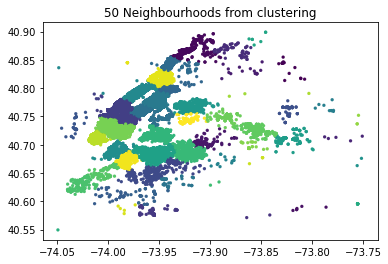

In [45]:
n_clusters = 50
clusters_k = "cluster_"+str(n_clusters)
index_c = (df_train.longitude>-74.05)&(df_train.longitude<-73.75)&(df_train.latitude>40.4)&(df_train.latitude<40.9)

clusters,brc = cluster_latlon(n_clusters,df_train.loc[index_c])

In [46]:
df_train[clusters_k] = -1
df_train.loc[index_c,clusters_k] = clusters

In [47]:
clusters2rank = df_train.loc[df_train[clusters_k]!= -1 , clusters_k].value_counts(ascending= True).rank(method = 'first')
clusters2rank[-1] = 0
df_train['cluster_rank'] = -1
df_train.loc[df_train[clusters_k]!= -1 , 'cluster_rank'] = df_train[clusters_k].map(lambda x: int(clusters2rank[int(x)]) -1)

2. Rotation

In [48]:
import math
def cart2rho(x, y):
    rho = np.sqrt(x**2 + y**2)
    return rho


def cart2phi(x, y):
    phi = np.arctan2(y, x)
    return phi


def rotation_x(row, alpha):
    x = row['latitude']
    y = row['longitude']
    return x*math.cos(alpha) + y*math.sin(alpha)


def rotation_y(row, alpha):
    x = row['latitude']
    y = row['longitude']
    return y*math.cos(alpha) - x*math.sin(alpha)


def add_rotation(degrees, df):
    namex = "rot" + str(degrees) + "_X"
    namey = "rot" + str(degrees) + "_Y"

    df['num_' + namex] = df.apply(lambda row: rotation_x(row, math.pi/(180/degrees)), axis=1)
    df['num_' + namey] = df.apply(lambda row: rotation_y(row, math.pi/(180/degrees)), axis=1)

    return df

def operate_on_coordinates(tr_df, te_df):
    for df in [tr_df, te_df]:
        #polar coordinates system
        df["num_rho"] = df.apply(lambda x: cart2rho(x["latitude"] - 40.78222222, x["longitude"]+73.96527777), axis=1)
        df["num_phi"] = df.apply(lambda x: cart2phi(x["latitude"] - 40.78222222, x["longitude"]+73.96527777), axis=1)
        #rotations
        for angle in [15,30,45,60]:
            df = add_rotation(angle, df)

    return tr_df, te_df

train_df, test_df = operate_on_coordinates(df_train, df_test)


In [ ]:
features_to_use.extend(['num_rho', 'num_phi', 'num_rot15_X', 'num_rot15_Y', 'num_rot30_X',
       'num_rot30_Y', 'num_rot45_X', 'num_rot45_Y', 'num_rot60_X',
       'num_rot60_Y'])

In [49]:
interest_level = pd.get_dummies(df_train['interest_level'],columns=['interest_level'])

In [50]:
cluster_df = pd.concat([df_train[['cluster_50','price_t','price_t1']],interest_level],axis= 1)
cluster_df = cluster_df.groupby(by = 'cluster_50').agg([np.mean,np.std,np.median])

In [52]:
df_train['cluster_low'] = df_train['cluster_50'].apply(lambda x: cluster_df.loc[x,( 'low','mean')])
df_train['cluster_medium'] = df_train['cluster_50'].apply(lambda x: cluster_df.loc[x,( 'medium','mean')])
df_train['cluster_high'] =df_train['cluster_50'].apply(lambda x: cluster_df.loc[x,( 'high','mean')])
df_train['cluster_skill'] = 2 * df_train['cluster_high'] + df_train['cluster_medium']

df_train['cluster_p_mean'] =df_train['cluster_50'].apply(lambda x: cluster_df.loc[x,( 'price_t','mean')])
df_train['cluster_p_median'] =df_train['cluster_50'].apply(lambda x: cluster_df.loc[x,( 'price_t','median')])
df_train['cluster_p_std'] =df_train['cluster_50'].apply(lambda x: cluster_df.loc[x,( 'price_t','std')])

df_train['cluster_p1_mean'] =df_train['cluster_50'].apply(lambda x: cluster_df.loc[x,( 'price_t1','mean')])
df_train['cluster_p1_median'] =df_train['cluster_50'].apply(lambda x: cluster_df.loc[x,( 'price_t1','median')])
df_train['cluster_p1_std'] =df_train['cluster_50'].apply(lambda x: cluster_df.loc[x,( 'price_t1','std')])


df_train['rel_cluster_p'] = (df_train['price_t'] - df_train['cluster_p_mean']) / df_train['cluster_p_std']
df_train['rel_cluster_p1'] = (df_train['price_t1'] - df_train['cluster_p1_mean']) / df_train['cluster_p1_std']

df_train['rel_cluster_p_median'] = df_train['price_t'] / df_train['cluster_p_median']
df_train['rel_cluster_p1_median'] = df_train['price_t1']/ df_train['cluster_p1_median']

In [26]:
features_to_add = [
    'cluster_rank','cluster_skill',
    'cluster_low','cluster_medium','cluster_high',
    'cluster_p_mean','cluster_p1_mean',
    'cluster_p_median','cluster_p1_median',
    'rel_cluster_p','rel_cluster_p1',
    'rel_cluster_p_median','rel_cluster_p1_median'
    ]
features_to_use.extend(features_to_add)

### manager_id

In [53]:
manager_df = pd.concat([df_train['manager_id'],interest_level],axis= 1)
manager_df = manager_df.groupby(by = 'manager_id').agg(np.mean)
manager_df['manager_skill'] = 2 * manager_df['high']  + 1 * manager_df['medium']
manager_df['m_vec'] = manager_df.apply(lambda x: (x.high,x.medium, x.low),axis=1)


df_train['manager_high'] = df_train.manager_id.apply(lambda x : manager_df.loc[x,'high'])
df_train['manager_medium'] = df_train.manager_id.apply(lambda x : manager_df.loc[x,'medium'])
df_train['manager_low'] = df_train.manager_id.apply(lambda x : manager_df.loc[x,'low'])
df_train['manager_skill'] = 2* df_train['manager_high'] + df_train['manager_medium']

In [28]:
features_to_add = ['manager_high','manager_medium','manager_low','manager_skill']
features_to_use.extend(features_to_add)

## description
### basic capture of descriptions


In [57]:
def cap_share(x):
    return sum(1 for c in x if c.isupper())/float(len(x)+1)

# do you think that users might feel annoyed BY A DESCRIPTION THAT IS SHOUTING AT THEM?
df_train['num_cap_share'] = df_train['description'].apply(cap_share)

# how long in lines the desc is?
df_train['num_nr_of_lines'] = df_train['description'].apply(lambda x: x.count('<br /><br />'))

# is the description redacted by the website?
df_train['num_redacted'] = 0
df_train.loc[df_train['description'].str.contains('website_redacted'),'num_redacted'] = 1

# can we contact someone via e-mail to ask for the details?
df_train['num_email'] = 0
df_train.loc[df_train['description'].str.contains('@'),'num_email'] = 1


df_train['num_description_words'] = df_train['description'].apply(lambda x: len(x.split()))

In [34]:
features_to_add = ['num_description_words','num_email','num_redacted','num_nr_of_lines','num_cap_share']
features_to_use.extend(features_to_add)

### description


In [60]:
for i in df_train['description']:
  text = i.lower()

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

stop = stopwords.words('english')

def cleaning_text(sentence):
   word_stemmer = PorterStemmer()
   sentence=sentence.lower()
   sentence=re.sub('[^\w\s]',' ', sentence) #removes punctuations
   sentence=re.sub('\d+',' ', sentence) #removes digits
   cleaned=' '.join([w for w in sentence.split() if not w in stop]) # removes english stopwords
   cleaned=' '.join([w for w , pos in pos_tag(cleaned.split()) if (pos == 'NN' or pos=='JJ' or pos=='JJR' or pos=='JJS' )])
   #selecting only nouns and adjectives
   cleaned=' '.join([word_stemmer.stem(w) for w in cleaned.split() if not len(w)<=2 ]) #removes single lettered words and digits
   cleaned=cleaned.strip()
   return cleaned

df_train['cleaned']= df_train['description'].apply(lambda x: cleaning_text(x))

# df_train['cfeatures']=df_train['features'].apply(lambda x: ', '.join(x))
# df_train['feat_cleaned']= df_train['cfeatures'].apply(lambda x: cleaning_text(x))
# df_train["final_feat"] = df_train["cleaned"].map(str) +" "+df_train["feat_cleaned"]
# df_train['final_feat'].head()

In [63]:
df_test['cleaned']= df_test['description'].apply(lambda x: cleaning_text(x))

# df_test['cfeatures']=df_test['features'].apply(lambda x: ', '.join(x))
# df_test['feat_cleaned']= df_test['cfeatures'].apply(lambda x: cleaning_text(x))
# df_test["final_feat"] = df_test["cleaned"].map(str) +" "+df_test["feat_cleaned"]
# df_test['final_feat'].head()

In [64]:
from sklearn.feature_extraction.text import CountVectorizer #Can use tfidffvectorizer as well

cvect_desc = CountVectorizer(stop_words='english', max_features=200)

train_sparse = cvect_desc.fit_transform(df_train.cleaned)
col_desc = [i for i in cvect_desc.get_feature_names()]
train_des_count = pd.DataFrame(train_sparse.todense(), columns=col_desc,index = df_train.index)
train_des_count = pd.concat([train_des_count,df_train.interest_level],axis = 1)

train_des_count['interest_level'] = df_train.interest_level

test_sparse = cvect_desc.transform(df_test.cleaned)
test_des_count = pd.DataFrame(test_sparse.todense(), columns=col_desc)

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_desc = TfidfVectorizer(stop_words='english', max_features=200)

train_sparse_tf = tfidf_desc.fit_transform(df_train.cleaned)
col_desc_tf = [i for i in tfidf_desc.get_feature_names()]
train_des_tf = pd.DataFrame(train_sparse_tf.todense(), columns=col_desc_tf,index = df_train.index)
train_des_tf = pd.concat([train_des_tf,df_train.interest_level],axis = 1)

test_sparse_tf = tfidf_desc.transform(df_test.cleaned)
test_des_tf = pd.DataFrame(test_sparse_tf.todense(), columns=col_desc_tf)

In [67]:
from sklearn.ensemble import GradientBoostingClassifier  as GBM
from sklearn.ensemble import RandomForestClassifier  as RF
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

def run_mod(dev_X, val_X,dev_Y,test_X):
    reg = GBM(max_features = 'auto',n_estimators=200,random_state=1)
    reg.fit(dev_X,dev_Y)
    val_pred = reg.predict_proba(val_X)
    imp = reg.feature_importances_
    test_pred = reg.predict_proba(test_X)
    return val_pred,imp,test_pred

In [66]:
def cross_val(train_df,test_df,features_to_use,split):
    cv_scores = []
    importances = []
    test_preds = []
    val_indices = []
    val_preds = []

    target_num_map = {'high':0, 'medium':1, 'low':2}
    train_X = train_df[features_to_use]
    train_Y = train_df['interest_level'].apply(lambda x: target_num_map[x])

    train_X = np.array(train_X)
    train_Y = np.array(train_Y)

    test_X = test_df[features_to_use]
    test_X = np.array(test_X)

    kf = StratifiedKFold(n_splits=split, shuffle=True, random_state=1)
    for dev_index, val_index in kf.split(train_X,train_Y):
            dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
            dev_Y, val_Y = train_Y[dev_index,], train_Y[val_index,]
            val_pred,imp,test_pred = run_mod(dev_X, val_X,dev_Y,test_X)
            cv_scores.append(log_loss(val_Y, val_pred))
            importances.append(imp)

            val_indices.append(val_index)
            val_preds.append(val_pred)

            test_preds.append(test_pred)
    return np.mean(cv_scores),importances,val_indices,val_preds,test_preds

In [ ]:
cv_score,imp,test_preds,val_indices,val_preds,test_preds = cross_val(train_des_tf,test_des_tf,test_des_tf.columns,split = 5)

In [ ]:
df_test['tf_pred'] = np.mean(test_preds,axis = 0)
#print np.average(importances,axis=0)#%%
df_test.to_csv(PATH + 'df_test.csv')

In [ ]:
val_preds_df = pd.DataFrame(columns = ['high','medium','low'])

for i in range(len(val_indices)):
  for j in range(len(val_indices[0])):
    val_preds_df.loc[val_indices[i][j]] = val_preds[i][j]
val_preds_df

### features

In [ ]:
def clean(s):
    x = s.replace("-", "")
    x = s.replace('!','')
    x = x.replace(" ", "")
    x = x.replace("twenty four hour", "24")
    x = x.replace("24/7", "24")
    x = x.replace("24hr", "24")
    x = x.replace("24-hour", "24")
    x = x.replace("24hour", "24")
    x = x.replace("24 hour", "24")
    x = x.replace("common", "cm")
    x = x.replace("concierge", "doorman")
    x = x.replace("bicycle", "bike")
    x = x.replace("private", "pv")
    x = x.replace("deco", "dc")
    x = x.replace("decorative", "dc")
    x = x.replace("onsite", "os")
    x = x.replace("outdoor", "od")
    x = x.replace("ss appliances", "stainless")
    return x

def features_clean(features):
    curr_features = []
    cleaned_features = []
    for text in features:
        if '*' in text:
            curr_features.extend(i for i in text.split('*') if i != '')
        else:
            curr_features.append(text)
    for text in curr_features:
        tmp = text.lower().strip()
        tmp = clean(tmp)
        cleaned_features.append(tmp)
    return cleaned_features

In [ ]:
df_train['clean_features'] =df_train.features.map(features_clean)


In [ ]:
k = 4
N = 60

feature_key_counts = Counter()
for feature in df_train['clean_features']:
    feature_keys = [f[:k] for f in feature]
    feature_key_counts.update(feature_keys)

most_common_keys = set(val[0] for val in feature_key_counts.most_common(N))

In [ ]:
def num_common_feature(l,k=k,most_common_keys = most_common_keys):
    count = 0
    for i in l:
        if i[:k] in most_common_keys:
            count += 1
    return count

In [ ]:
df_train['num_common_features'] = df_train.clean_features.map(num_common_feature)

In [ ]:
features_to_add = ['num_common_features']
features_to_use.extend(features_to_add)

In [ ]:
from sklearn import preprocessing
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if df_train[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            df_train[f] = lbl.transform(list(train_df[f].values))
            df_test[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)


In [ ]:
def group_with_time_features(data, g_feat):
    mean_month_dict = dict(data.groupby(g_feat)['created_month'].mean())
    data["mean_" + g_feat + "_month"] = data.apply(lambda row: mean_month_dict[row[g_feat]], axis=1)
    mean_day_dict = dict(data.groupby(g_feat)['created_day'].mean())
    data["mean_" + g_feat + "_day"] = data.apply(lambda row: mean_day_dict[row[g_feat]], axis=1)
    mean_hour_dict = dict(data.groupby(g_feat)['created_hour'].mean())
    data["mean_" + g_feat + "_hour"] = data.apply(lambda row: mean_hour_dict[row[g_feat]], axis=1)
    mean_weekday_dict = dict(data.groupby(g_feat)['created_dayofweek'].mean())
    data["mean_" + g_feat + "_weekday"] = data.apply(lambda row: mean_weekday_dict[row[g_feat]], axis=1)
    mean_passed_dict = dict(data.groupby(g_feat)['total_days'].mean())
    data["mean_" + g_feat + "_passed"] = data.apply(lambda row: mean_passed_dict[row[g_feat]], axis=1)
    return data

g_feat = 'manager_id'
group_with_time_features(df_train,g_feat)
features_to_add = ["mean_" + g_feat + "_month","mean_" + g_feat + "_day","mean_" + g_feat + "_hour","mean_" + g_feat + "_weekday","mean_" + g_feat + "_passed"]

In [ ]:
X = df_train[features_to_use]
y = df_train.interest_level
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [ ]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train,y_train)
y_val_pred = clf.predict_proba(X_val)
log_loss(y_val, y_val_pred)

In [ ]:
def runXGB(train_X, train_y, val_X, val_y=None, test_X=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.03
    param['max_depth'] = 6
    param['verbose'] = 0
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    param['nthread'] = 12
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if val_y is not None:
        xgval = xgb.DMatrix(val_X, label=val_y)
        watchlist = [ (xgtrain,'train'), (xgval, 'val') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50)
    else:
        model = xgb.train(plst, xgtrain, num_rounds)
    # xgtest = xgb.DMatrix(test_X)

    # pred_test_y = model.predict(xgtest)
    # return pred_test_y, model
    return model

In [ ]:
target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(df_train['interest_level'].apply(lambda x: target_num_map[x]))

In [ ]:
cv_scores = []
test_pred = None
train_X = df_train[features_to_use]

kf = KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        model = runXGB(dev_X, dev_y, val_X, val_y,  num_rounds=2000)


In [ ]:
test_pred /= 5
out_df = pd.DataFrame(test_pred)
out_df.columns = ["high", "medium", "low"]

pd.get_dummies(df_train,columns= ['interest_level'])

In [ ]:
from xgboost import plot_importance
plot_importance(model)

In [ ]:


df_train.columns

In [ ]:
df_train.tail()

In [ ]:
df_train.to_csv(PATH + 'df_train.csv')